In [1]:
import pandas as pd
import numpy as np
from random import randint

## Step 1: Getting Data Ready

In [2]:
# Storing dataset into a Pandas DataFrame
heart_disease_df = pd.read_csv("datasets/heart-disease.csv")

In [3]:
# Printing head of DataFrame to make sure the data has been loaded correctly
heart_disease_df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
# Using Random seed to make results reproducible:
np.random.seed(42)
# Creating X & Y, where:
# X: Feature columns in DataFrame (whatever is needed for predicting)
# Y: Column to be predicted
X = heart_disease_df.drop('target',axis = 1)
Y = heart_disease_df['target']

### Splitting dataset into train, validation, and test sets using the train_test_split method twice:

In [5]:
from sklearn.model_selection import train_test_split
# Splitting dataset into train, validation, and test sets using the train_test_split method twice:

X_train_valid,X_test,Y_train_valid,Y_test = train_test_split(X,Y,test_size = 0.2)

In [6]:
X_train,X_valid,Y_train,Y_valid = train_test_split(X_train_valid,Y_train_valid,train_size = 0.7)

In [7]:
# Looking at shapes to ensure that the dataset was split properly:
X_train.shape,Y_train.shape,X_valid.shape,Y_valid.shape,X_test.shape,Y_test.shape

((169, 13), (169,), (73, 13), (73,), (61, 13), (61,))

## Step 2: Choosing the Model
Done by following the Model Selection Map. In this example, it's a Classification problem.
<br>This step involves trying different models.
<br>RandomForestClassifier from sklearn.ensemble is used.

In [8]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()

## Step 3: Fitting Model to Data & Making Predictions

In [9]:
# Fitting training data to model using fit () method
model.fit(X_train, Y_train)

RandomForestClassifier()

Instantiating Calibration Model:

In [10]:
from sklearn.calibration import CalibratedClassifierCV
# 2 models are created to observe how sigmoid & isotonic models perform
sig_model = CalibratedClassifierCV(model,method="sigmoid",cv=5)
iso_model = CalibratedClassifierCV(model,method="isotonic",cv=5)

In [11]:
# Fitting validation dataset to calibration models using fit () method
sig_model.fit(X_valid, Y_valid)
iso_model.fit(X_valid, Y_valid)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(), cv=5,
                       method='isotonic')

In [12]:
# Making predictions using predict() method:
Y_pred = model.predict(X_test)

In [13]:
# Calibrated models' predictions:
Y_sig_pred = sig_model.predict(X_test)
Y_iso_pred = iso_model.predict(X_test)

In [14]:
# Making predictions using predict_proba() method: (uncalibrated model)
Y_prob_pred = model.predict_proba(X_test)

In [15]:
# Making predictions using predict_proba() method: (calibrated models)
Y_prob_sig_pred = sig_model.predict_proba(X_test)
Y_prob_iso_pred = iso_model.predict_proba(X_test)

## Step 4: Evaluating Model

### 4.1: Using `score()` method:

In [16]:
# Perform .score on test set: (Uncalibrated Model)
print("Uncalibrated: " + str(model.score(X_test, Y_test)))

Uncalibrated: 0.8360655737704918


In [17]:
# Perform .score on test set: (Calibrated Models)
sig_model.score(X_test, Y_test)
print("Sigmoid: " + str(sig_model.score(X_test, Y_test)))
print("Isotonic " + str(iso_model.score(X_test, Y_test)))

Sigmoid: 0.8524590163934426
Isotonic 0.8688524590163934


### 4.2: Using **Scoring** parameters:

#### a) Cross-Validation Accuracy:

In [18]:
from sklearn.model_selection import cross_val_score
# 5-fold Cross-val score: 
cv_score_array = cross_val_score(model, X, Y, cv=5)
print("CV Accuracy for Uncalibrated Model = " + str (np.mean(cv_score_array)))
cv_score_array = cross_val_score(sig_model, X, Y, cv=5)
print("CV Accuracy for Calibrated Model (Sigmoid) = " + str (np.mean(cv_score_array)))
cv_score_array = cross_val_score(iso_model, X, Y, cv=5)
print("CV Accuracy for Calibrated Model (Isotonic) = " + str (np.mean(cv_score_array)))

CV Accuracy for Uncalibrated Model = 0.8381420765027323
CV Accuracy for Calibrated Model (Sigmoid) = 0.834808743169399
CV Accuracy for Calibrated Model (Isotonic) = 0.8216939890710384


#### b) Area Under the Curve (AUC/ROC):
- `predict_proba()` is used for this metric

In [19]:
# Finding Prediction Probability:
Y_probs_pred = model.predict_proba(X_test)
Y_prob_sig_pred = sig_model.predict_proba(X_test)
Y_prob_iso_pred = iso_model.predict_proba(X_test)

In [20]:
# Left column represents probability of prediction being *False* while right column represents probability of prediction being *True*
Y_positive = Y_probs_pred[:,1]
Y_positive_sig = Y_prob_sig_pred[:,1]
Y_positive_iso = Y_prob_iso_pred[:,1]

##### Calculating FPR, TPR,and Thresholds:

In [21]:
# Importing roc_curve:
from sklearn.metrics import roc_curve
fpr,tpr,thresholds = roc_curve(Y_test,Y_positive)

fpr_sig,tpr_sig,thresholds_sig = roc_curve(Y_test,Y_positive_sig)
fpr_iso,tpr_iso,thresholds_iso = roc_curve(Y_test,Y_positive_iso)

##### Plotting function

In [22]:
import matplotlib.pyplot as plt

In [23]:
def plot_roc_curve(fpr,tpr,fpr_sig,tpr_sig, fpr_iso, tpr_iso):
    """ Plots ROC Curve given False Positive Right (FPR) & True Positive Right (TPR)"""
    
    # Plot Uncalibrated ROC Curve:
    plt.plot(fpr, tpr, color = "orange", label = "ROC")
    
    # Plot Sigmoid ROC Curve:
    plt.plot(fpr_sig, tpr_sig, color = "m", label = "ROC - Sigmoid")
    
    # Plot Isotonic ROC Curve:
    plt.plot(fpr_iso, tpr_iso, color = "c", label = "ROC - Isotonic")    
    
    #Plot baseline:
    plt.plot([0,1],[0,1], color = "darkblue", linestyle = "--", label = "Guessing")
    
    # Customizing Plot:
    plt.xlabel = "FPR"
    plt.ylabel = "TPR"
    plt.title = "ROC Curve"
    plt.legend()
    plt.show()

    

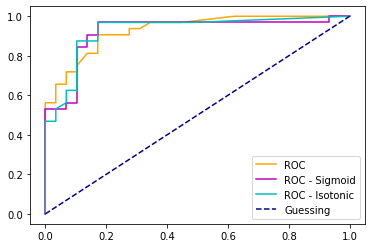

In [24]:
plot_roc_curve(fpr,tpr,fpr_sig,tpr_sig,fpr_iso,tpr_iso)

- ROC Scores

In [25]:
from sklearn.metrics import roc_auc_score
print("ROC for uncalibrated Model: " + str(roc_auc_score(Y_test,Y_positive)))
print("ROC for calibrated Model (Sigmoid): " + str(roc_auc_score(Y_test,Y_positive_sig)))
print("ROC for calibrated Model (Isotonic): " + str(roc_auc_score(Y_test,Y_positive_iso)))

ROC for uncalibrated Model: 0.9299568965517241
ROC for calibrated Model (Sigmoid): 0.9202586206896552
ROC for calibrated Model (Isotonic): 0.9267241379310345


##### Confusion Matrix:
- Also known as an **Error Matrix**.
- Quick way to compare a model's **predicted labels** with the **actual labels** it was supposed to predict.
- Not strictly used for **binary classification** problems.
- Gives you an idea where the model gets confused.

##### Visualizing Confusion Matrix using `sklearn.ConfusionMatrixDisplay`:
1. From Estimator (includes training & validation sets).
2. From Predictions (only includes test set).

In [26]:
from sklearn.metrics import ConfusionMatrixDisplay

##### Using from_estimator:

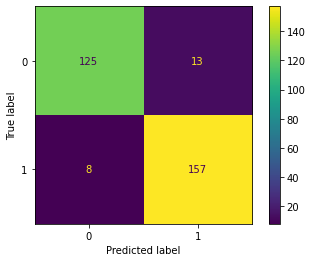

In [27]:
# Uncalibrated Model:
ConfusionMatrixDisplay.from_estimator(estimator = model, X= X, y=Y)

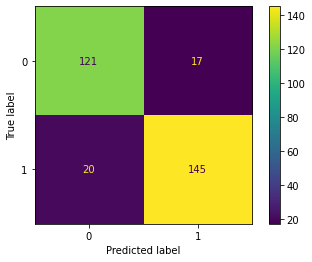

In [28]:
# Calibrated Model: (Sigmoid)
ConfusionMatrixDisplay.from_estimator(estimator = sig_model, X= X, y=Y)

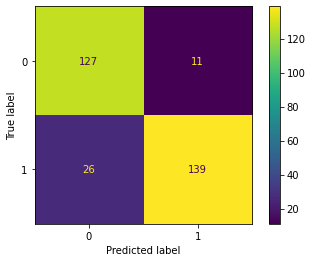

In [29]:
# Calibrated Model: (Isotonic)
ConfusionMatrixDisplay.from_estimator(estimator = iso_model, X= X, y=Y)

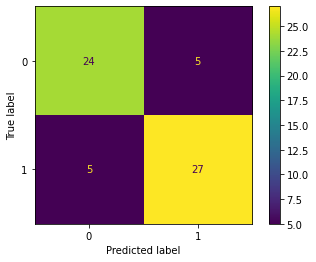

In [30]:
# Using from_predictions - Uncalibrated Model:
ConfusionMatrixDisplay.from_predictions(y_true = Y_test, y_pred = Y_pred)

##### Using from_predictions:

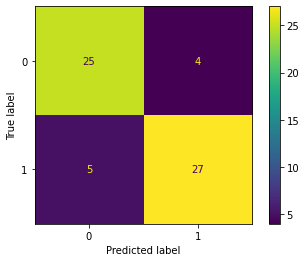

In [31]:
# Calibrated Model: (Sigmoid)
ConfusionMatrixDisplay.from_predictions(y_true = Y_test, y_pred = Y_sig_pred)

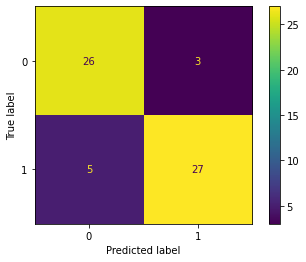

In [32]:
# Calibrated Model: (Isotonic)
ConfusionMatrixDisplay.from_predictions(y_true = Y_test, y_pred = Y_iso_pred)

### Classification Report:

#### For Uncalibrated Model:

In [33]:
from sklearn.metrics import classification_report
print (classification_report(Y_test,Y_pred))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83        29
           1       0.84      0.84      0.84        32

    accuracy                           0.84        61
   macro avg       0.84      0.84      0.84        61
weighted avg       0.84      0.84      0.84        61



#### For Calibrated Model: (Sigmoid)

In [34]:
from sklearn.metrics import classification_report
print (classification_report(Y_test,Y_sig_pred))

              precision    recall  f1-score   support

           0       0.83      0.86      0.85        29
           1       0.87      0.84      0.86        32

    accuracy                           0.85        61
   macro avg       0.85      0.85      0.85        61
weighted avg       0.85      0.85      0.85        61



#### For Calibrated Model: (Isotonic)

In [35]:
from sklearn.metrics import classification_report
print (classification_report(Y_test,Y_iso_pred))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87        29
           1       0.90      0.84      0.87        32

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



## Step 5: Improving Model


In [36]:
# Try different numbers of estimators with cross-validation and no cross-validation

from sklearn.model_selection import cross_val_score

for i in range(10, 100, 10):
    print(f"Trying model with {i} estimators...")
    model = RandomForestClassifier(n_estimators=i).fit(X_train, Y_train)
    print(f"Model accruacy on test set: {model.score(X_test, Y_test)}")
    print(f"Cross-validation score: {np.mean(cross_val_score(model, X, Y, cv=5)) * 100}%")
    print("")

Trying model with 10 estimators...
Model accruacy on test set: 0.7704918032786885
Cross-validation score: 79.8688524590164%

Trying model with 20 estimators...
Model accruacy on test set: 0.8360655737704918
Cross-validation score: 80.50819672131148%

Trying model with 30 estimators...
Model accruacy on test set: 0.8524590163934426
Cross-validation score: 79.18032786885246%

Trying model with 40 estimators...
Model accruacy on test set: 0.8688524590163934
Cross-validation score: 82.50273224043717%

Trying model with 50 estimators...
Model accruacy on test set: 0.8688524590163934
Cross-validation score: 81.50273224043715%

Trying model with 60 estimators...
Model accruacy on test set: 0.8688524590163934
Cross-validation score: 82.49726775956283%

Trying model with 70 estimators...
Model accruacy on test set: 0.8360655737704918
Cross-validation score: 81.83060109289617%

Trying model with 80 estimators...
Model accruacy on test set: 0.8688524590163934
Cross-validation score: 81.8306010928

## Step 6: Saving Trained Model

In [37]:
import pickle

# Save trained model to file
pickle.dump(model, open("random_forest_model_1.pkl", "wb"))